# 1. Configuración del Ambiente


In [45]:
# Importar librerías de manipulación de datos
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


In [46]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
print("Versión de pandas:", pd.__version__)

# Verificar la versión de numpy
print("Versión de numpy:", np.__version__)

# Verificar la versión de matplotlib
print("Versión de matplotlib:", matplotlib.__version__)

Versión de pandas: 1.5.3
Versión de numpy: 1.23.5
Versión de matplotlib: 3.7.0


## 2.1 Precios Históricos del Bitcoin

In [47]:
def importar_base_bitcoin():
    global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    end_date = datetime.now()
    start_date = end_date- timedelta(days=7)

    #Descargar datos de bitocoin usando yfinance
    df_bitcoin = yf.download("BTC-USD", start=start_date, end=end_date, interval="5m")

    print("Datos de las últimas 24 horas fueron decargados correctamente")



In [48]:

def flatten_multiindex_columns(separator='_', rename_dict=None):

    rename_dict = {
    'Close_BTC-USD': 'Close_BTC',
    'High_BTC-USD': 'High_BTC',
    'Low_BTC-USD': 'Low_BTC',
    'Open_BTC-USD': 'Open_BTC',
    'Volume_BTC-USD': 'Volumen_BTC',
    'Datetime': 'FechaHora'
}

    """
    Aplana las columnas MultiIndex de un DataFrame global (df_bitcoin)
    y renombra las columnas según un diccionario opcional.

    Modifica el DataFrame global df_bitcoin.

    :param separator: Separador utilizado para combinar los niveles del MultiIndex.
    :param rename_dict: Diccionario opcional para renombrar columnas.
    """
    global df_bitcoin

    # Verificar si las columnas tienen MultiIndex
    if isinstance(df_bitcoin.columns, pd.MultiIndex):
        # Aplanar el MultiIndex combinando los niveles con el separador especificado
        df_bitcoin.columns = [
            separator.join([str(part) for part in col if part]) if isinstance(col, tuple) else col
            for col in df_bitcoin.columns.values
        ]
        print("Las columnas con MultiIndex han sido aplanadas.")
    else:
        print("El DataFrame no tiene MultiIndex en las columnas. No se realizaron cambios.")
    
    # Renombrar las columnas si se proporciona un diccionario de renombrado
    if rename_dict:
        # Verificar que las columnas a renombrar existen en el DataFrame
        valid_columns = {key: value for key, value in rename_dict.items() if key in df_bitcoin.columns}
        df_bitcoin.rename(columns=valid_columns, inplace=True)
        print("Las columnas han sido renombradas según el diccionario proporcionado.")




In [49]:
importar_base_bitcoin()
flatten_multiindex_columns()
df_bitcoin.head(100)

[*********************100%***********************]  1 of 1 completed

Datos de las últimas 24 horas fueron decargados correctamente
Las columnas con MultiIndex han sido aplanadas.
Las columnas han sido renombradas según el diccionario proporcionado.


,Close_BTC,High_BTC,Low_BTC,Open_BTC,Volumen_BTC
Datetime,,,,,
2025-01-18 16:10:00+00:00,104285.335938,104567.218750,104285.335938,104567.218750,0
2025-01-18 16:15:00+00:00,103765.953125,104267.570312,103765.953125,104267.570312,0
2025-01-18 16:20:00+00:00,104099.765625,104099.765625,103865.257812,103865.257812,0
2025-01-18 16:25:00+00:00,103971.148438,104012.375000,103971.148438,104012.375000,0
2025-01-18 16:30:00+00:00,104121.468750,104121.468750,103915.578125,103926.976562,0
...,...,...,...,...,...
2025-01-19 00:05:00+00:00,104338.179688,104338.179688,104294.140625,104294.140625,0
2025-01-19 00:10:00+00:00,104249.609375,104319.085938,104237.968750,104319.085938,0
2025-01-19 00:15:00+00:00,104272.609375,104272.609375,104210.117188,104210.117188,0


In [50]:
campos = df_bitcoin.columns

print("Campos del DataFrame:")
print(campos)

Campos del DataFrame:
Index(['Close_BTC', 'High_BTC', 'Low_BTC', 'Open_BTC', 'Volumen_BTC'], dtype='object')


# ATENCION
# Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona revisen la estructura actualizada del HTML.

## 2.2 Indicadores de Tendencias

In [51]:
import requests
from bs4 import BeautifulSoup

# Declaramos las variables globales
precio_actual = None
tendencia = None
color = None

def extraer_tendencias():
    """
    Realiza un web scraping a la página de Bitcoin en CoinMarketCap
    y asigna a variables globales el precio, la tendencia y el color.
    Retorna una tupla con (precio_actual, tendencia, color).
    """
    global precio_actual, tendencia, color
    
    url = "https://coinmarketcap.com/currencies/bitcoin/"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # 1. Extraer el elemento <p> que indica la tendencia
        trend_element = soup.find("p", class_="change-text")
        
        if trend_element:
            color = trend_element.get("color", "")
            data_change = trend_element.get("data-change", "")
            
            if color.lower() == "green" and data_change.lower() == "up":
                tendencia = "alta"
            elif color.lower() == "red" and data_change.lower() == "down":
                tendencia = "baja"
            else:
                tendencia = f"Estado no identificado (color={color}, data-change={data_change})"
        else:
            color = ""
            tendencia = "No se encontró el elemento con la clase 'change-text'."
        
        # 2. Extraer el precio de Bitcoin y convertirlo a número entero
        price_element = soup.find("span", attrs={"data-test": "text-cdp-price-display"})
        
        if price_element:
            # Ejemplo de texto: "$96,977.64"
            precio_str = price_element.text.strip()
            
            # 1. Eliminar símbolo '$' y comas
            precio_str = precio_str.replace("$", "").replace(",", "")
            
            # 2. Convertir a float para poder eliminar los decimales
            try:
                precio_float = float(precio_str)
                # 3. Convertir a entero (truncar decimales)
                precio_actual = int(precio_float)
            except ValueError:
                # Si hubiera algún problema de conversión, asigna un mensaje de error
                precio_actual = "Error al convertir el precio a entero."
        else:
            precio_actual = "No se encontró el elemento del precio."
    
    else:
        # Si no se puede acceder correctamente a la página, asignamos un mensaje de error
        precio_actual = f"Error al acceder a la página. Código de estado: {response.status_code}"
        tendencia = ""
        color = ""
    
    # Retornamos una tupla con los valores
    return precio_actual, tendencia, color


# Ejemplo de uso
if __name__ == "__main__":
    extraer_tendencias()
    print("Precio actual (entero):", precio_actual)
    print("Tendencia:", tendencia)
    print("Color:", color)



Precio actual (entero): 104939
Tendencia: baja
Color: red


In [52]:
extraer_tendencias()
print(f"Precio actual de Bitcoin: {precio_actual}")
print(f"Tendencia: {tendencia}")


Precio actual de Bitcoin: 104939
Tendencia: baja


# 3. Limpieza de datos

## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [53]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())

df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2025-01-18 16:10:00+00:00 to 2025-01-25 16:05:00+00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_BTC    2016 non-null   float64
 1   High_BTC     2016 non-null   float64
 2   Low_BTC      2016 non-null   float64
 3   Open_BTC     2016 non-null   float64
 4   Volumen_BTC  2016 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.5 KB
None


,Close_BTC,High_BTC,Low_BTC,Open_BTC,Volumen_BTC
count,2016.0,2016.0,2016.0,2016.0,2.016000e+03
mean,104367.0,104446.0,104282.0,104363.0,8.820228e+07
std,1567.0,1564.0,1577.0,1572.0,2.411231e+08
min,99722.0,99941.0,99623.0,99623.0,0.000000e+00
25%,103494.0,103598.0,103377.0,103491.0,0.000000e+00
50%,104530.0,104586.0,104475.0,104531.0,0.000000e+00
75%,105248.0,105293.0,105155.0,105233.0,7.471309e+07
max,108897.0,109110.0,108711.0,108900.0,3.901678e+09


## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

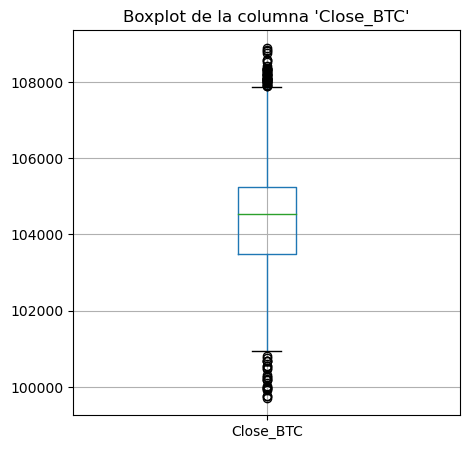

In [54]:
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close_BTC'])

# Renderizar el gráfico
plt.title("Boxplot de la columna 'Close_BTC'")
plt.show()

## 3.3 Función para la limpieza de los datos de Bitcoin

In [55]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin

    # Número inicial de datos
    num_datos_inicial = df_bitcoin.shape[0]
    print(f"Número inicial de datos: {num_datos_inicial}")

    # Copiar el DataFrame original para no modificarlo directamente
    df_bitcoin_limpio = df_bitcoin.copy()

    # Paso 1: Eliminar índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Paso 2: Rellenar valores nulos en la columna 'Close_BTC' con el último valor válido
    df_bitcoin_limpio['Close_BTC'] = df_bitcoin_limpio['Close_BTC'].ffill()
    
    # Paso 3: Eliminar filas con volumen igual o menor a cero
    num_datos_antes_volumen = df_bitcoin_limpio.shape[0]
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volumen_BTC'] > 0]
    print(f"Filas eliminadas por volumen cero o negativo: {num_datos_antes_volumen - df_bitcoin_limpio.shape[0]}")

    # Paso 4: Calcular el rango intercuartílico (IQR)
    Q1 = df_bitcoin_limpio['Close_BTC'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close_BTC'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Paso 5: Eliminar outliers en la columna 'Close_BTC'
    num_datos_antes_outliers = df_bitcoin_limpio.shape[0]
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close_BTC'] >= limite_inferior) &
                                          (df_bitcoin_limpio['Close_BTC'] <= limite_superior)]
    print(f"Outliers eliminados: {num_datos_antes_outliers - df_bitcoin_limpio.shape[0]}")

    # Paso 6: Calcular el precio promedio de Bitcoin después de la limpieza
    media_bitcoin = df_bitcoin_limpio['Close_BTC'].mean()
    print(f"Precio promedio de Bitcoin después de la limpieza: {media_bitcoin}")


## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

Número inicial de datos: 2016
Filas eliminadas por volumen cero o negativo: 1189
Outliers eliminados: 0
Precio promedio de Bitcoin después de la limpieza: 104070.60439653869


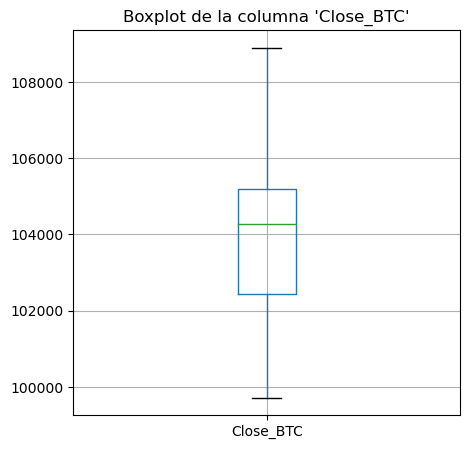

In [56]:
limpieza_datos()
#Muestra el Boxplot de la base limpia

df_bitcoin_limpio.boxplot(['Close_BTC'])
# Renderizar el gráfico
plt.title("Boxplot de la columna 'Close_BTC'")
plt.show()

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

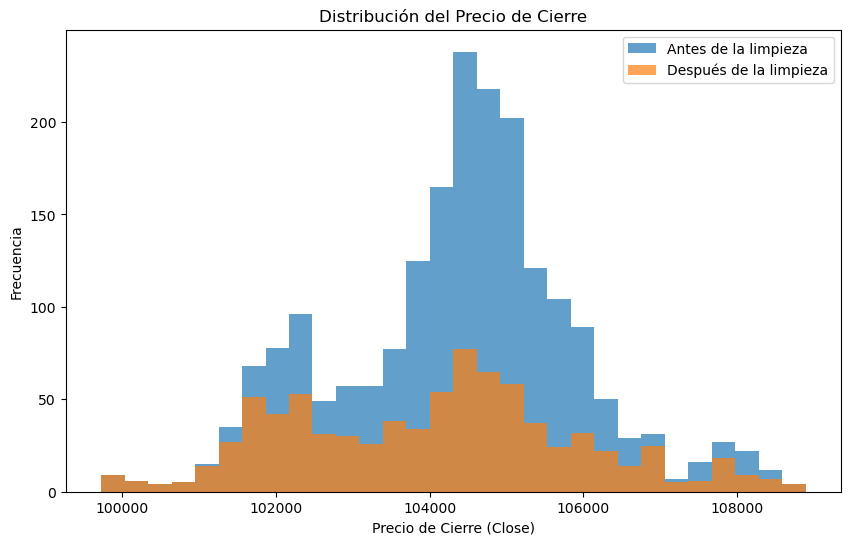

In [57]:
#@title Gráfico de distribución del Precio de Cierre antes y después de la limpieza { display-mode: "form" }
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10, 6))
plt.hist(df_bitcoin['Close_BTC'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close_BTC'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias moviles

In [58]:
def calcular_sma():
    """
    Calcula las medias móviles simples (SMA) de corto y largo plazo para los precios de cierre de Bitcoin.
    """
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (10 periodos por defecto)
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close_BTC'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (50 periodos por defecto)
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close_BTC'].rolling(window=50).mean()

In [59]:
calcular_sma()
print(df_bitcoin_limpio.head(10))

                               Close_BTC       High_BTC        Low_BTC       Open_BTC  Volumen_BTC      SMA_corto  SMA_largo
Datetime                                                                                                                    
2025-01-18 18:45:00+00:00  104238.695312  104238.695312  104173.007812  104173.007812     25415680            NaN        NaN
2025-01-18 22:05:00+00:00  103821.914062  103825.562500  103821.914062  103825.562500     10432512            NaN        NaN
2025-01-18 23:05:00+00:00  104406.218750  104406.218750  104376.250000  104382.367188     50790400            NaN        NaN
2025-01-18 23:10:00+00:00  104442.796875  104442.796875  104371.234375  104371.234375     76451840            NaN        NaN
2025-01-18 23:15:00+00:00  104532.375000  104532.375000  104446.500000  104449.992188     55554048            NaN        NaN
2025-01-18 23:20:00+00:00  104488.789062  104488.789062  104457.039062  104457.039062     94937088            NaN        NaN


## 4.2 Evaluar datos y tomar decision

In [60]:
def tomar_decisiones() -> None:
    """
    Toma decisiones de compra, venta o mantenimiento basadas en SMA y tendencia.

    Modifica las variables globales:
    - algoritmo_decision
    - color
    """
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color, df_bitcoin_limpio

    # Obtener las últimas SMA calculadas en el DataFrame df_bitcoin_limpio
    try:
        sma_corto_actual = df_bitcoin_limpio['SMA_corto'].iloc[-1]
        sma_largo_actual = df_bitcoin_limpio['SMA_largo'].iloc[-1]
    except (KeyError, IndexError) as e:
        print(f"Error al obtener SMA: {e}")
        return

    # Verificar si los valores de tendencia están definidos correctamente
    if tendencia not in ['alta', 'baja']:
        print(f"Tendencia inválida: {tendencia}. Las tendencias válidas son 'alta' o 'baja'.")
        return

    # Algoritmo de decisión basado en SMA y tendencia actuales
    if (sma_corto_actual > sma_largo_actual) and (tendencia == 'alta'):
        # Condición para Comprar
        algoritmo_decision = "comprar"
        color = "#32cd32"  # Verde
    elif (sma_corto_actual < sma_largo_actual) and (tendencia == 'baja'):
        # Condición para Vender
        algoritmo_decision = "vender"
        color = "#dc143c"  # Rojo
    else:
        # Condición para Mantener
        algoritmo_decision = "mantener"
        color = "#000000"  # Negro

    # Imprimir el resultado de la decisión
    print(f"Decisión: {algoritmo_decision.capitalize()} | "
          f"SMA Corta: {sma_corto_actual:.2f}, SMA Larga: {sma_largo_actual:.2f}, "
          f"Tendencia: {tendencia.capitalize()}")



# ATENCION
# Recuerden que la tendencia de una hora puede cambiar rápidamente.
# Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

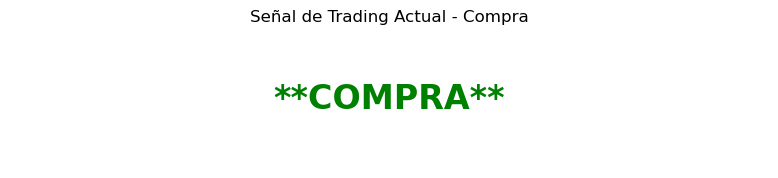

In [61]:
def graficar_senal_actual():
    """
    Muestra un gráfico simple con la señal de trading actual (compra/venta) utilizando matplotlib.
    
    Dependencias: 
    - algoritmo_decision (variable global): Decisión del algoritmo de trading.
    - color (variable global): Color de la señal en el gráfico.
    """
    global algoritmo_decision, color  # Declarar variables globales dentro de la función
    
    # Configuración básica de la figura
    fig, ax = plt.subplots(figsize=(8, 2))  # Ancho y alto de la figura en pulgadas
    
    # Validación de variables globales
    if not algoritmo_decision or not color:
        print("Error: Variables globales 'algoritmo_decision' y 'color' deben estar definidas.")
        return
    
    # Dibujar un texto con la decisión de trading como señal
    ax.text(0.5, 0.5, f"**{algoritmo_decision.upper()}**", 
            ha='center', va='center', size=24, 
            color=color, fontweight='bold')
    
    # Personalización del gráfico
    ax.axis('off')  # Ocultar ejes
    ax.set_title(f"Señal de Trading Actual - {algoritmo_decision.capitalize()}")
    
    # Ajustar el layout para que el título quepe bien y evitar márgenes innecesarios
    fig.tight_layout(pad=1.5)
    
    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    # Asignar valores a las variables globales
    algoritmo_decision = "compra"
    color = "green" if algoritmo_decision.lower() == "compra" else "red"
    
    # Llamar a la función para graficar la señal
    graficar_senal_actual()


In [62]:
def graficar_decisiones():
    global df_bitcoin_limpio, algoritmo_decision, precio_actual, color
    """
    Genera un gráfico con las SMA de corto y largo plazo, junto con la decisión actual.

    :param df_bitcoin_limpio: DataFrame con las columnas 'Close_BTC', 'SMA_corto', 'SMA_largo'.
    :param algoritmo_decision: Decisión actual ('comprar', 'vender', 'mantener').
    :param precio_actual: Precio actual del Bitcoin.
    :param color: Color asociado a la decisión (verde, rojo, negro).
    """
    plt.figure(figsize=(12, 6))

    # Gráfico de los precios de cierre
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close_BTC'], color='gray', alpha=0.7, label='Precio de Cierre (Original)')

    # SMA de corto plazo
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], linestyle='--', color='blue', label='SMA Corta (10)')

    # SMA de largo plazo
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], linestyle='--', color='orange', label='SMA Larga (50)')

    # Añadir marcador de decisión actual
    plt.scatter(df_bitcoin_limpio.index[-1], precio_actual, color=color, edgecolor='black', s=100, label='Señal de Decisión Actual', marker='v')

    # Añadir texto de decisión actual
    plt.text(df_bitcoin_limpio.index[-1], precio_actual, f" Decisión Actual: {algoritmo_decision.capitalize()}",
             color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.8, edgecolor='black'))

    # Configuración de etiquetas y leyendas
    plt.title("Señal de Compra/Venta en Base a SMA con Dataset Original", fontsize=14)
    plt.xlabel("Tiempo")
    plt.ylabel("Precio")
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    # Mostrar gráfico
    plt.show()


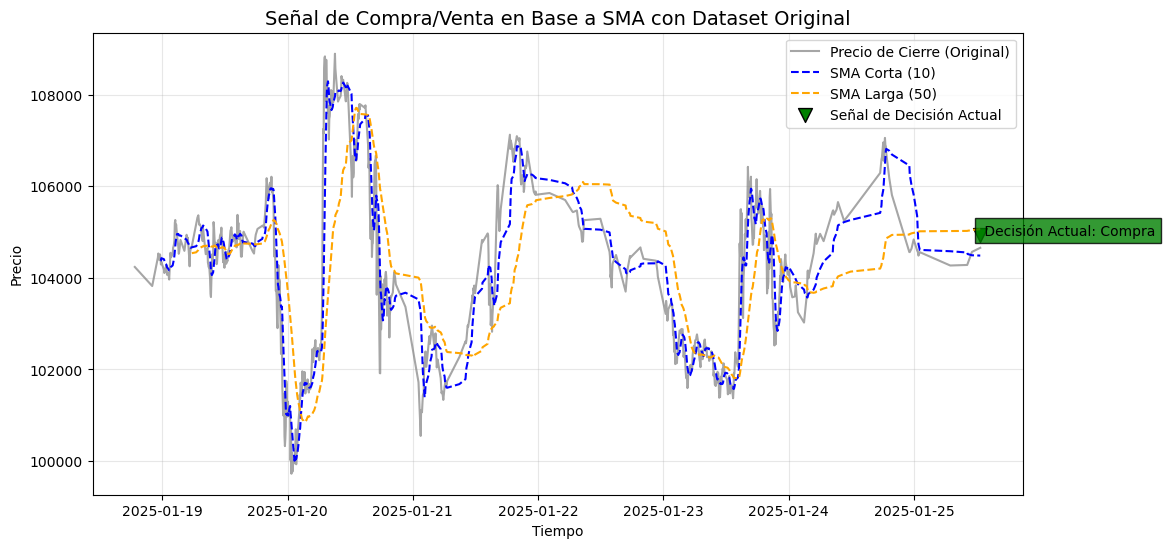

In [63]:
graficar_decisiones()

# 6. Ciclo

In [64]:
''''while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    flatten_multiindex_columns()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma()

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones()

    # Paso 4: Graficar las tendencias y señales

    graficar_senal_actual()
    graficar_decisiones()

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(300)

SyntaxError: incomplete input (3331207950.py, line 1)

In [ ]:
df_bitcoin_limpio.to_csv('Bitcoin_limpio.csv', index=False)